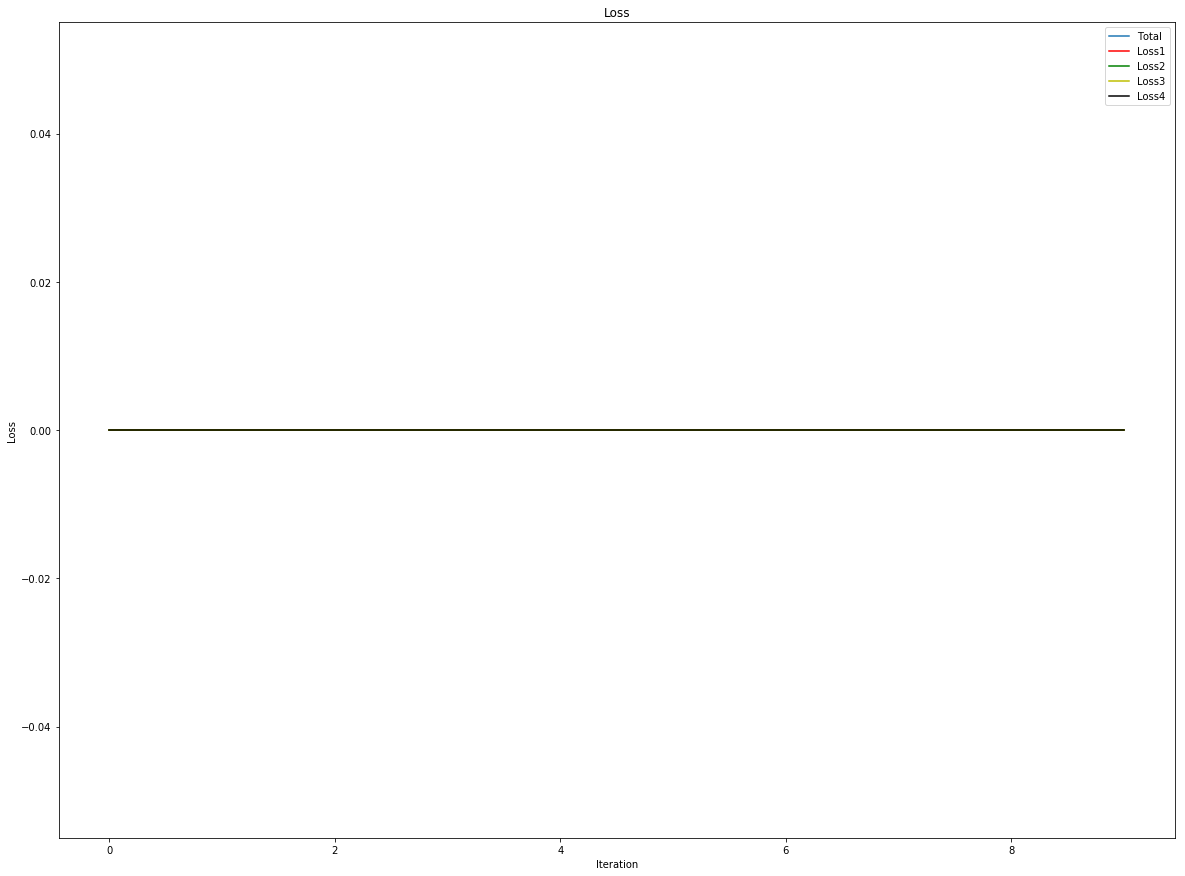

In [7]:
import os
import pickle
from pprint import pprint
import datetime
import numpy as np
from matplotlib import pyplot as plt

dirname = 'results'

losses = pickle.load(open(dirname+'/loss.pkl', 'rb'))
# losses = np.random.randn(100, 4)
N_iters = losses.shape[0]

# Plot total loss
plt.figure(figsize=(20, 15))
total = plt.plot(range(N_iters), np.sum(losses, axis=1), label='Total')
plt.title('Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
# plt.show()

# Plot respective losses
colors = ['r', 'g', 'y', 'k']
for i in range(4):
    plt.plot(range(N_iters), losses[:, i], colors[i], label='Loss' + str(i+1))

plt.legend(loc='upper right')
plt.show()

In [6]:
# Display hyperparameters and run information

params = pickle.load(open(dirname+'/hyperparameters.pkl', 'rb'))
pprint(params)

runtime = pickle.load(open(dirname+'/runtime.pkl', 'rb'))
print('\nRuntime: ' + str(datetime.timedelta(seconds=runtime)))

{'epochs': 1,
 'lambdas': (1, 0.01, 0, 50),
 'learning_rate': 0.0001,
 'multiplier': 0.0001,
 'n_processes': 6,
 'nb_data': 10}

Runtime: 0:00:16.190033
